# Sparse Matrix Application: Conjugate Gradient for Solving Linear Systems

Welcome to the first homework for the high-performance computation of sparse matrices! In this work, you'll try to solve postive-definite sparse linear systems with Conjugate Gradient method.

By the end of this homework, you are expected to be able to:

- Understand the advantage of compressed storage format of sparse matrix over traditional 2D storage format for Sparse Matrix Vector product operation (SpMV). 
- Understand the methology to solve linear system by iterative methods, especially Conjugate Gradient (CG).
- have a basic knowledge on the preconditioning techniques for iterative methods.

## Table of Contents
- [1 - Packages](#1)
- [2 - Test Matrix Collection](#2)
- [3 - Basic Conjugate Gradient Method](#3)
- [4 - Precondtioned Conjugate Gradient Method](#4)

<a name='1'></a>
## 1 - Packages

In [1]:
using LinearAlgebra
using SparseArrays
using Printf
using Random
using BenchmarkTools
using TimerOutputs
import MatrixDepot
import Plots

include group.jl for user defined matrix generators
verify download of index files...
reading database
adding metadata...
adding svd data...
writing database
used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index


<a name='2'></a>
## 2 - Test Matrix Collection

[MatrixDepot](https://github.com/JuliaMatrices/MatrixDepot.jl) is a Julia package, which provides an extensible test matrix collection. MatrixDepot provides an easy access to a public matrix collection [SuiteSparse Matrix Collection](https://sparse.tamu.edu/). 

The *SuiteSparse Matrix Collection* is a large and actively growing set of sparse matrices that arise in real applications. The Collection is widely used by the numerical linear algebra community for the development and performance evaluation of sparse matrix algorithms. The matrices in the Collection cover a wide spectrum of domains, including structural engineering, computational fluid dynamics, material science, acoustics, electromagnetic, thermodynamics, computer graphics and vision ......

<center>
<img src="../figs/SuiteSparsePlots.png" alt="centered image">
</center>
<caption><center><font color='purple'><b>Figure 1</b>: Sample Gallery of the SuiteSparse Matrix Collection https://sparse.tamu.edu/about </font></center></caption>

A [search engine](http://yifanhu.net/GALLERY/GRAPHS/search.html) is also available which is able to filter required matrices based different criterion. 

<center>
<img src="../figs/SuiteSparseSearch.png" alt="centered image">
</center>
<caption><center><font color='purple'><b>Figure 2</b>: Search engine for SuiteSparse Matrix Collection http://yifanhu.net/GALLERY/GRAPHS/search.html </font></center></caption>

## Load sparse from SuiteSparse Matrix Collection by MatrixDepot

MatrixDepot parses the name of matrix from SuiteSparse Matrix Collection through a combination of "group name" and "matrix name", e.g., "HB/nos3" refers to matrix "nos3" from the "HB group" (Harwell-Boeing collection).

In [2]:
#define matrix name in the format "group/matrix"
matname = "HB/nos3"
#load matrix through MatrixDepot
nos3 = MatrixDepot.matrixdepot(matname)
#Get information of loaded matrix
display(nos3)

960×960 Symmetric{Float64,SparseMatrixCSC{Float64,Int64}}:
  86.8678          4.88498e-15  …    0.0            0.0        0.0
   4.88498e-15   132.189             0.0            0.0        0.0
 -17.4635         -4.88498e-15       0.0            0.0        0.0
  -4.88498e-15  -107.898             0.0            0.0        0.0
   0.0             0.0               0.0            0.0        0.0
   0.0             0.0          …    0.0            0.0        0.0
   0.0             0.0               0.0            0.0        0.0
   0.0             0.0               0.0            0.0        0.0
   0.0             0.0               0.0            0.0        0.0
   0.0             0.0               0.0            0.0        0.0
   0.0             0.0          …    0.0            0.0        0.0
   0.0             0.0               0.0            0.0        0.0
   0.0             0.0               0.0            0.0        0.0
   ⋮                            ⋱                            
   0.0  

SuiteSparse Matrix Collection provides also the properties for each matrix, e.g., the number of rows/columns, number of nonzeros, symmetricity, scalar type, condition number, etc. For details about matrix "HB/nos3", please visit: https://www.cise.ufl.edu/research/sparse/matrices/HB/nos3.html

In [3]:
# Plot the sparsity pattern of loaded matrix
Plots.spy(nos3, legend = :none)

<a name='3'></a>
## 3 - Basic Conjugate Gradient Method

## Mathematical idea of CG

Suppose we want to solve the system of linear equations
$$Ax=b \tag{1}$$
in which $A$ is a $n\times n$ symmetric (i.e., $A^T = A$) and postive-definite (i.e. $x^TAx$ for all non-zero vectors $x\in \mathbb{R}^n$) matrix, $x$ and $b$ are both $n$-dimensional vector. 


## Algorithm of CG

## Implementation of Standard CG

We provides a simple implementation of CG as follows. This implementation uses a Julia package [TimerOutputs](https://github.com/KristofferC/TimerOutputs.jl) for recording the timings the different numerical kernels in CG.

The basic format of timings by **TimerOutputs** is 

either:

```Julia
@timeit Timer "Kernel name" {single line code for this kernel}
```

to record the timings of a single line of code;

or:

```Julia
@timeit Timer "Code block name" begin
    CODE BLOCK
end   
```

to record the timings of a defined code block.

This **timer** is disabled in default. when you first time go through the code, please just ignore these related marcos.


In [4]:
function CG(A, b, x; maxIter = 5000, tol=1e-10, verbosity = 0, timer = false)
    
    """
    A first implementation of Conjugate Gradient method to solve Ax=b.
    
    Arguments:
    A -- a sparse matrix of size N x N which determines a linear system
    b -- a vector of size N: right-hand side of a linear system
    x -- a vector of size N: initial guess solution of a linear system
    
    Optional:
    maxIter -- maximum iterative steps before the convergence criteria is satisfied, default value is 5000
    tol -- the convergence criteria, default value is 1e-10
    verbosity -- if print the convergence steps (yes, if it is > 0), default value is 0
    timer -- boolean value, indicating if recording the timings, default false
    
    Returns:
    x -- a vector of size N, the approximated solution of linear system
    errors -- a vector of size "step", which includes the convergence errors of solving procedure
    """
    
    Timer = TimerOutput()
    
    if timer
       enable_timer!(Timer) 
    end
    
    @timeit Timer "Total" begin
    
    @timeit Timer "SpMV" r = b - A * x
    @timeit Timer "Copy" p = r
    @timeit Timer "Dot" rsold = r' * r
    step = 0
    errors = zeros(maxIter)
    while step < maxIter
        step += 1  
        @timeit Timer "SpMV" Ap = A * p
        @timeit Timer "Dot" α = rsold / (p' * Ap)
        @timeit Timer "Axpy" x = x + α .* p 
        @timeit Timer "Axpy" r = r - α .* Ap
        @timeit Timer "Dot" rsnew = r' * r
        errors[step] = sqrt(rsnew) 
        if verbosity > 0
            msg = "CG: step: $step, resid: "
            msg *= @sprintf("%.12e\n", errors[step])
            printstyled(msg, bold=false, color=:green)
        end
        
        if sqrt(rsnew) < tol
            break
        end
        @timeit Timer "Axpy" p = r + (rsnew / rsold) * p
        rsold = rsnew
    end 
    end #end Timer "Total"
    
    if timer
        show(Timer)
    end
    return x, errors[1:step]
end

CG (generic function with 1 method)

Quesiton:
> Please identify the SpMV operation in the above function.

Answer:
> Line 28 in the previous cell, "Ap = A * p".

## First try with CG

We have a first try with CG using "HB/nos3" matrix.

In [5]:
### Get the row and column number of "HB/nos3" matrix
M = size(nos3, 1)
N = size(nos3, 2)
@info "(Row number, column number): " M, N
@info "The scalar type of matrix: " eltype(nos3)

┌ Info: (Row number, column number): 
│   (M, N) = (960, 960)
└ @ Main In[5]:4
┌ Info: The scalar type of matrix: 
│   eltype(nos3) = Float64
└ @ Main In[5]:5


In [6]:
## Generate a right-hand side in random which constructs a linear system
## together with "HB/nos3" matrix
b = randn(Float64, N)

## Generate a initial guess vector in random
x₀ = randn(Float64, N);

In [7]:
## Solve defined linear system by CG
x, errors = CG(nos3, b, x₀;verbosity = 1);

CG: step: 1, resid: 3.227829243773e+03
CG: step: 2, resid: 1.484746647025e+03
CG: step: 3, resid: 8.024111043496e+02
CG: step: 4, resid: 4.851692491582e+02
CG: step: 5, resid: 2.975929406952e+02
CG: step: 6, resid: 2.062656097827e+02
CG: step: 7, resid: 1.431572801203e+02
CG: step: 8, resid: 1.067309106503e+02
CG: step: 9, resid: 8.069118826629e+01
CG: step: 10, resid: 6.350033400180e+01
CG: step: 11, resid: 5.247412890574e+01
CG: step: 12, resid: 4.132344423348e+01
CG: step: 13, resid: 3.519596936712e+01
CG: step: 14, resid: 3.161931803188e+01
CG: step: 15, resid: 2.790674693678e+01
CG: step: 16, resid: 2.500513630823e+01
CG: step: 17, resid: 2.377135898457e+01
CG: step: 18, resid: 2.093991690516e+01
CG: step: 19, resid: 2.027137526253e+01
CG: step: 20, resid: 1.861653871091e+01
CG: step: 21, resid: 1.626897223350e+01
CG: step: 22, resid: 1.400253170469e+01
CG: step: 23, resid: 1.343876505620e+01
CG: step: 24, resid: 1.186112914596e+01
CG: step: 25, resid: 1.144545575671e+01
CG: step:

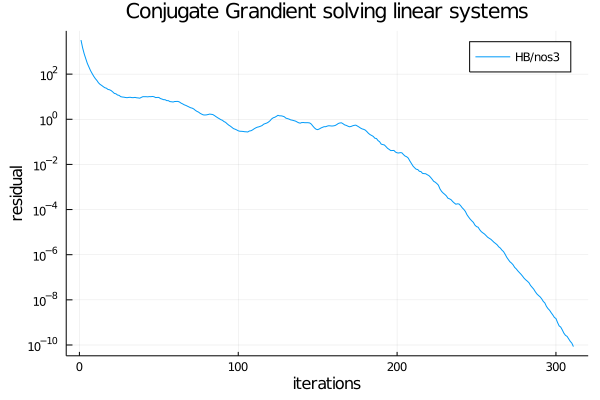

In [8]:
#Plot the convergence curve
Plots.plot(errors, title = "Conjugate Grandient solving linear systems", label = matname, ylabel = "residual", xlabel = "iterations", yaxis=:log)

In [9]:
##Compare the solution with the one of a direct solver
x2 = nos3 \ b
@info "Difference between CG solution and Direct solver solution: " maximum(abs.(x.-x2))

┌ Info: Difference between CG solution and Direct solver solution: 
│   maximum(abs.(x .- x2)) = 4.2291170565533776e-13
└ @ Main In[9]:3


Question: 
> What is the condition number of "HB/nos3"?

Answer:
> Write your answer here.

(Tips: the condition number can be found in the page of each matrix on the website of SuiteSparse Matrix Collection. It is denoted as *cond(A)* on the website.)

## Comparison of CG with Sparse Compressed storage format and 2D format

### Benchmark of CG using BenchmarkTools

In [10]:
### Sparse matrix in CSC format
@benchmark CG(nos3, b, x₀)

BenchmarkTools.Trial: 245 samples with 1 evaluation.
 Range (min … max):   6.221 ms … 207.776 ms  ┊ GC (min … max):  0.00% … 17.84%
 Time  (median):     12.696 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   20.397 ms ±  23.488 ms  ┊ GC (mean ± σ):  17.06% ± 20.54%

  █▆▅▅▄▃▄▃ ▁                                                    
  ██████████▆▆█▇▇▆▄▆▁▆▄▄▁▄▁▄▄▄▇▄▁▆▄▄▄▄▄▄▁▁▁▁▁▁▁▁▁▁▄▄▁▁▄▄▁▄▄▁▁▄ ▆
  6.22 ms       Histogram: log(frequency) by time       108 ms <

 Memory estimate: 16.26 MiB, allocs estimate: 2230.

In [11]:
### Sparse matrix in dense 2D format
@benchmark CG(Matrix(nos3), b, x₀)

BenchmarkTools.Trial: 61 samples with 1 evaluation.
 Range (min … max):  51.121 ms … 626.551 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     60.927 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   84.497 ms ±  94.560 ms  ┊ GC (mean ± σ):  2.10% ± 3.28%

  █                                                             
  █▇█▄▄▃▄▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃ ▁
  51.1 ms         Histogram: frequency by time          412 ms <

 Memory estimate: 23.42 MiB, allocs estimate: 2239.

Question: 
> How much averaged speedup has been obtained from dense matrix format to sparse matrix format on your laptop?

Answer:
> Write your answer here.

### Timings of different numerical kernels in CG

The **timer** is able to be enabled by explicitly set the optional argument `timer=true`.

In [12]:
### Sparse matrix in CSC format
CG(nos3, b, x₀; timer=true);

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      585ms / 1.96%           33.2MiB / 49.0%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 Total          1   11.5ms   100%  11.5ms   16.3MiB  100%   16.3MiB
   SpMV       312   8.57ms  74.6%  27.5μs   2.33MiB  14.3%  7.65KiB
   Axpy       932   2.20ms  19.2%  2.36μs   13.9MiB  85.4%  15.3KiB
   Dot        623    234μs  2.04%   375ns     0.00B  0.00%    0.00B
   Copy         1    392ns  0.00%   392ns     0.00B  0.00%    0.00B
 ──────────────────────────────────────────────────────────────────

In [13]:
### Sparse matrix in dense 2D format
CG(Matrix(nos3), b, x₀; timer=true);

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      280ms / 100%            16.3MiB / 100%     

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 Total          1    280ms   100%   280ms   16.3MiB  100%   16.3MiB
   SpMV       312    271ms  96.9%   870μs   2.33MiB  14.3%  7.65KiB
   Axpy       932   2.57ms  0.92%  2.75μs   13.9MiB  85.4%  15.3KiB
   Dot        623   2.34ms  0.84%  3.76μs     0.00B  0.00%    0.00B
   Copy         1    841ns  0.00%   841ns     0.00B  0.00%    0.00B
 ──────────────────────────────────────────────────────────────────

Question: 
> Compare the two tables of timings above, and describle your observation.

Answer:

> - SpMV is the most dominant kernel in CG;
> - SpMV with compressed format is almost 14x faster than the one with dense matrix format.

<a name='4'></a>
## 4 - Precondtioned Conjugate Gradient Method

Before the introduce of preconditioned Conjugate Gradient method (PCG), let's at first try solving another linear system by the standard CG.

In [14]:
matname = "HB/bcsstk15"
bcsstk15 = MatrixDepot.matrixdepot(matname)
bcsstk15d = Matrix(bcsstk15)
M = size(bcsstk15, 1)
N = size(bcsstk15, 2);
#matname = "Nasa/nasa4704"

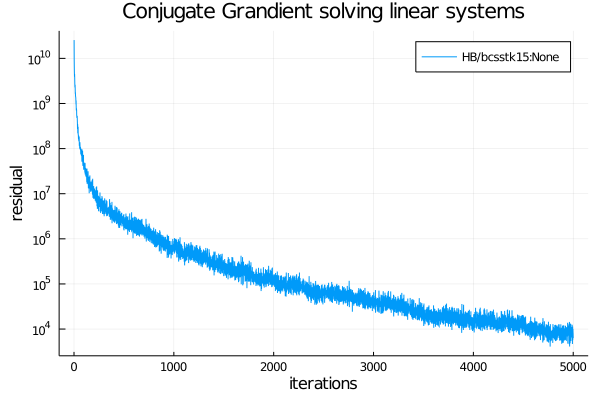

In [15]:
b = randn(eltype(bcsstk15), N)
x₀ = randn(eltype(bcsstk15), N);
x, errors = CG(bcsstk15, b, x₀;verbosity = 0)
Plots.plot(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":None", ylabel = "residual", xlabel = "iterations", yaxis=:log)

A quick conclusion:
> Standard CG fails to achieve the convergence in 5000 steps for linear system constructed by "HB/bcsstk15" matrix.

Question:
> What is the condition number of "HB/bcsstk15" matrix?

Answer:
> Write your answer here.

## Mathematical idea of PCG

## Implementation of PCG

We provides a simple implementation of PCG as follows:

In [16]:
function PCG(A, b, x, M; maxIter = 5000, tol=1e-10, verbosity = 0, timer = false)
    
    
    """
    A first implementation of Conjugate Gradient method to solve Ax=b.
    
    Arguments:
    A -- a sparse matrix of size N x N which determines a linear system
    b -- a vector of size N: right-hand side of a linear system
    x -- a vector of size N: initial guess solution of a linear system
    M -- a matrix of size N x N, it is the preconditioning matrix to speedup
         the convergence of CG. It is constructed externally in different manners.
    
    Optional:
    maxIter -- maximum iterative steps before the convergence criteria is satisfied, default value is 5000
    tol -- the convergence criteria, default value is 1e-10
    verbosity -- if print the convergence steps (yes, if it is > 0), default value is 0
    timer -- boolean value, indicating if recording the timings, default false
    
    Returns:
    x -- a vector of size N, the approximated solution of linear system
    errors -- a vector of size "step", which includes the convergence errors of solving procedure
    """
    
    Timer = TimerOutput()
    
    if timer
       enable_timer!(Timer) 
    end
    
    @timeit Timer "Total" begin
        
    @timeit Timer "SpMV" r = b - A * x
    @timeit Timer "MV(Precond)" z = M * r
    @timeit Timer "Copy" p = z
    @timeit Timer "Dot" rsold = r' * z
    step = 0
    errors = zeros(maxIter)
    
    while step < maxIter
        step += 1
        @timeit Timer "SpMV" Ap = A * p
        @timeit Timer "Dot" α = rsold / (p' * Ap)
        @timeit Timer "Axpy" x = x + α * p 
        @timeit Timer "Axpy" r = r - α * Ap
        @timeit Timer "Dot" errors[step] = sqrt(r'*r)
        if verbosity > 0
            msg = "CG: step: $step, resid: "
            msg *= @sprintf("%.12e\n", errors[step])
            printstyled(msg, bold=false, color=:green)
        end
        
        if errors[step] < tol
            break
        end
        @timeit Timer "MV(Precond)" z = M * r
        @timeit Timer "Dot" rsnew = r' * z
        @timeit Timer "Axpy" p = z + (rsnew / rsold) * p
        rsold = rsnew
    end 
        
    end #end Timer "Total"

    if timer
       show(Timer) 
    end
    
    return x, errors[1:step]
end

PCG (generic function with 1 method)

## Preconditioners
### Jacobi Preconditioner

The Jacobi preconditioner is one of the simplest forms of preconditioning, in which the preconditioner is chosen to be the diagonal of the matrix $P=diag(A)$.  It is efficient for diagonally dominant matrices.

┌ Info: Required iteration number with Jacobi preconditioner is: 
│   size(errors, 1) = 920
└ @ Main In[17]:5


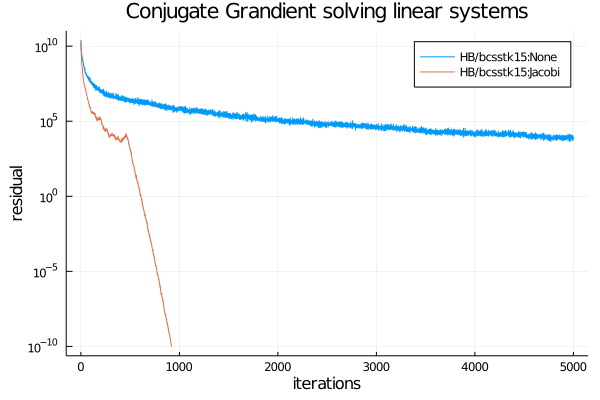

In [17]:
## Construct the Jacobi precontioning matrix as (diag(A))^{-1}
PJacobi = inv(Diagonal(bcsstk15d))
## Appy the Jacobi preconditioning matrix to PCG
x, errors = PCG(bcsstk15, b, x₀, SparseMatrixCSC(PJacobi); verbosity = 0)
@info "Required iteration number with Jacobi preconditioner is: " size(errors,1)
## Add the convergence curve to plot
Plots.plot!(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":Jacobi", ylabel = "residual", xlabel = "iterations", yaxis=:log)

### SSOR Preconditioner

In applied mathematics, symmetric successive over-relaxation (SSOR), is a preconditioner. Suppose that an original matrix $A$ is split into diagonal, lower
and upper triangular as $A=D+L+U$, then a SSOR preconditioning matrix can be defined as:

$$P=(D+L)D^{-1}(D+L)^T$$

It can also be parametrised by $\omega$ as:

$$P(\omega)=\frac{\omega}{2-\omega}(\frac{1}{\omega}D+L)D^{-1}(\frac{1}{\omega}D+L)^T$$

A function to construct the SSOR preconitioning matrix is given as follows:

In [18]:
function SSOR(A; ω=1)    
    
    """
    A first implementation of Conjugate Gradient method to solve Ax=b.
    
    Arguments:
    A -- a sparse matrix of size N x N which determines a linear system
    
    Optional:
    ω -- a scalar: SSOR parameter

    Returns:
    M -- a N x N preconditioning matrix
    """
    
    n = size(A, 1)
    Ad = Matrix(A)
    D = LinearAlgebra.Diagonal(Ad)
    L = LinearAlgebra.LowerTriangular(Ad)

    #M = (D + ω * L) * inv(D) * (D + ω * U)
    M = (ω/(2-ω)) .* ((1/ω) .* D + L) * inv(D) * ((1/ω) .* D + L)'
    return M
end

SSOR (generic function with 1 method)

┌ Info: Required iteration number with SSOR preconditioner is: 
│   size(errors, 1) = 436
└ @ Main In[19]:6


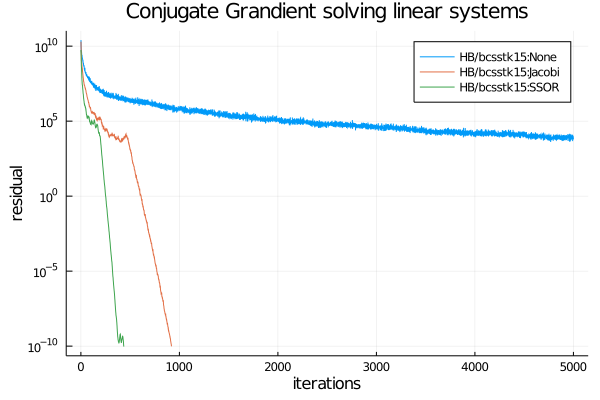

In [19]:
## Construct the SSOR precontioning matrix by function SSOR(A; ω=1.8)
ω = 1.8
PSSOR = inv(SSOR(bcsstk15d; ω=ω))
## Appy the SSOR preconditioning matrix to PCG
x, errors = PCG(bcsstk15, b, x₀, PSSOR; verbosity = 0)
@info "Required iteration number with SSOR preconditioner is: " size(errors,1)
## Add the convergence curve to plot
Plots.plot!(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":SSOR", ylabel = "residual", xlabel = "iterations", yaxis=:log)

### Timings of different preconditioners

In [20]:
CG(bcsstk15, b, x₀;verbosity = 0, timer=true);

PCG(bcsstk15, b, x₀, SparseMatrixCSC(PJacobi); verbosity = 0, timer=true);

PCG(bcsstk15, b, x₀, PSSOR; verbosity = 0, timer=true);

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      1.18s / 100%            1.03GiB / 100%     

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 Total          1    1.18s   100%   1.18s   1.03GiB  100%   1.03GiB
   Axpy     15.0k    610ms  51.6%  40.6μs    907MiB  85.7%  61.9KiB
   SpMV     5.00k    556ms  47.0%   111μs    151MiB  14.3%  31.0KiB
   Dot      10.0k   10.7ms  0.90%  1.07μs     0.00B  0.00%    0.00B
   Copy         1    272ns  0.00%   272ns     0.00B  0.00%    0.00B
 ────────────────────────────────────────────────────────────────── ────────────────────────────────────────────────────────────────────────
                                 Time                   Allocations      
                         ───────────

In [21]:
@info "Sparsity of Jacobi preconditioning matrix" nnz(SparseMatrixCSC(PJacobi)) / (N * N)
@info "Sparsity of SSOR preconditioning matrix" nnz(SparseMatrixCSC(PSSOR)) / (N * N)

┌ Info: Sparsity of Jacobi preconditioning matrix
│   nnz(SparseMatrixCSC(PJacobi)) / (N * N) = 0.00025329280648429586
└ @ Main In[21]:1
┌ Info: Sparsity of SSOR preconditioning matrix
│   nnz(SparseMatrixCSC(PSSOR)) / (N * N) = 0.9969466925143379
└ @ Main In[21]:2


Question:
> Describe your observations by comparing the above three tables

Answer:
> Write your answer here.

(Tips: Considering the sparsity of different preconditioning matrix)

### Condition number of preconditioned linear system

The PCG with precondtioning matrix M is equivalent to applying the conjugate gradient method without preconditioning to the system
$$L^{-1}A(L^{-1})^T\hat{x} = L^{-1}b$$

where 
$$LL^T = M, \quad \hat{x} = E^Tx$$

Thus the condition number of preconditioned linear system is:

$$cond(L^{-1}A(L^{-1})^T)$$

#### Condition number of Jacobi preconditioned linear system

In [22]:
LJacobi = sqrt.(Diagonal(bcsstk15d))
@info "Condition number of Jacobi preconditioned linear system" cond(inv(LJacobi) * bcsstk15d * (inv(LJacobi))' )

┌ Info: Condition number of Jacobi preconditioned linear system
│   cond(inv(LJacobi) * bcsstk15d * (inv(LJacobi))') = 82087.05385844235
└ @ Main In[22]:2


#### Condition number of SSOR preconditioned linear system

In [23]:
DSSOR = LinearAlgebra.Diagonal(bcsstk15d)
LSSOR = LinearAlgebra.LowerTriangular(bcsstk15d)
LSSOR = sqrt(ω/(2-ω)) .* ((1/ω) .* DSSOR + LSSOR) * sqrt.((inv(DSSOR)))
@info "Condition number of SSOR preconditioned linear system" cond(inv(LSSOR) * bcsstk15d * (inv(LSSOR))' ) 

┌ Info: Condition number of SSOR preconditioned linear system
│   cond(inv(LSSOR) * bcsstk15d * (inv(LSSOR))') = 12181.412203563317
└ @ Main In[23]:4


ToDo: Please fill in the table below with the previously obtained data

| HB/bcsstk15 | None | Jacobi | SSOR |
| :------: | :------: | :------: | :------: |
|Iteration number||||
|Condition number||||
|Total Time(s)||||
|SpMV Time(s)||||
|MV(Precond) ||||

## Play with more matrices

### Matrix: Nasa/nasa4704

┌ Info: Required iteration number without preconditioner is: 
│   size(errors, 1) = 5000
└ @ Main In[24]:15


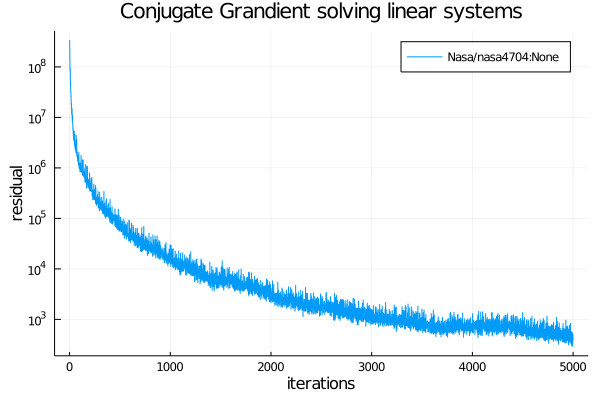

In [24]:
matname = "Nasa/nasa4704"

verb = 0

nasa4704 = MatrixDepot.matrixdepot(matname)
nasa4704d = Matrix(nasa4704)
M = size(nasa4704, 1)
N = size(nasa4704, 2);

b = randn(eltype(nasa4704), N)
x₀ = randn(eltype(nasa4704), N);

#standard CG
x, errors = CG(nasa4704, b, x₀;verbosity = verb)
@info "Required iteration number without preconditioner is: " size(errors,1)
Plots.plot(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":None", ylabel = "residual", xlabel = "iterations", yaxis=:log)

┌ Info: Required iteration number with Jacobi preconditioner is: 
│   size(errors, 1) = 5000
└ @ Main In[25]:5


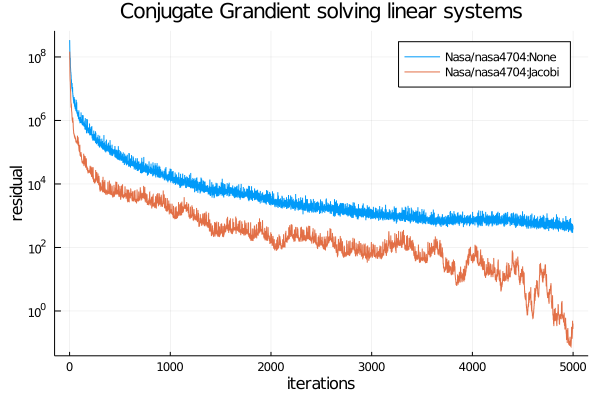

In [25]:
## Construct the Jacobi precontioning matrix as (diag(A))^{-1}
PJacobi = inv(Diagonal(nasa4704d))
## Appy the Jacobi preconditioning matrix to PCG
x, errors = PCG(nasa4704, b, x₀, SparseMatrixCSC(PJacobi); verbosity = verb)
@info "Required iteration number with Jacobi preconditioner is: " size(errors,1)
Plots.plot!(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":Jacobi", ylabel = "residual", xlabel = "iterations", yaxis=:log)

┌ Info: Required iteration number with SSOR preconditioner is: 
│   size(errors, 1) = 2992
└ @ Main In[26]:7


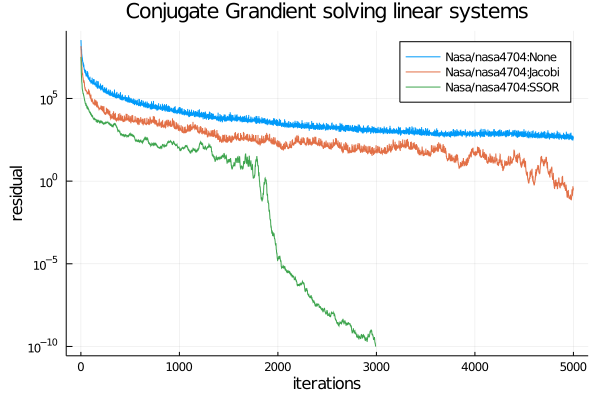

In [26]:
## Construct the SSOR precontioning matrix by function SSOR(A; ω=1.8)
ω = 1.8
PSSOR = inv(SSOR(nasa4704d; ω=ω))

## Appy the SSOR preconditioning matrix to PCG
x, errors = PCG(nasa4704, b, x₀, PSSOR; verbosity = verb)
@info "Required iteration number with SSOR preconditioner is: " size(errors,1)
Plots.plot!(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":SSOR", ylabel = "residual", xlabel = "iterations", yaxis=:log)

In [27]:
## recording timings for diferent kernels
CG(nasa4704, b, x₀;verbosity = 0, timer=true);

PCG(nasa4704, b, x₀, SparseMatrixCSC(PJacobi); verbosity = 0, timer=true);

PCG(nasa4704, b, x₀, PSSOR; verbosity = 0, timer=true);

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      1.55s / 100%            1.23GiB / 100%     

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 Total          1    1.55s   100%   1.55s   1.23GiB  100%   1.23GiB
   Axpy     15.0k    964ms  62.1%  64.3μs   1.05GiB  85.7%  73.7KiB
   SpMV     5.00k    567ms  36.5%   113μs    180MiB  14.3%  36.8KiB
   Dot      10.0k   15.6ms  1.00%  1.56μs     0.00B  0.00%    0.00B
   Copy         1    419ns  0.00%   419ns     0.00B  0.00%    0.00B
 ────────────────────────────────────────────────────────────────── ────────────────────────────────────────────────────────────────────────
                                 Time                   Allocations      
                         ───────────

In [28]:
## Compute condition number of precondtioned linear system
LJacobi = sqrt.(Diagonal(nasa4704d))
@info "Condition number of Jacobi preconditioned linear system" cond(inv(LJacobi) * nasa4704d * (inv(LJacobi))' )

DSSOR = LinearAlgebra.Diagonal(nasa4704d)
LSSOR = LinearAlgebra.LowerTriangular(nasa4704d)
LSSOR = sqrt(ω/(2-ω)) .* ((1/ω) .* DSSOR + LSSOR) * sqrt.((inv(DSSOR)))
@info "Condition number of SSOR preconditioned linear system" cond(inv(LSSOR) * nasa4704d * (inv(LSSOR))' ) 

┌ Info: Condition number of Jacobi preconditioned linear system
│   cond(inv(LJacobi) * nasa4704d * (inv(LJacobi))') = 8.075455097655151e6
└ @ Main In[28]:3
┌ Info: Condition number of SSOR preconditioned linear system
│   cond(inv(LSSOR) * nasa4704d * (inv(LSSOR))') = 1.179572174075985e6
└ @ Main In[28]:8


ToDo: Please fill in the table below with the previously obtained data

| Nasa/nasa4704 | None | Jacobi | SSOR |
| :------: | :------: | :------: | :------: |
|Iteration number||||
|Condition number||||
|Total Time(s)||||
|SpMV Time(s)||||
|MV(Precond) ||||

### Matrix: Boeing/crystm01

In [29]:
matname = "Boeing/crystm01"

verb = 0

crystm01= MatrixDepot.matrixdepot(matname)
crystm01d = Matrix(crystm01)
M = size(crystm01, 1)
N = size(crystm01, 2);

b = randn(eltype(crystm01), N)
x₀ = randn(eltype(crystm01), N);

┌ Info: Required iteration number without preconditioner is: 
│   size(errors, 1) = 168
└ @ Main In[30]:3


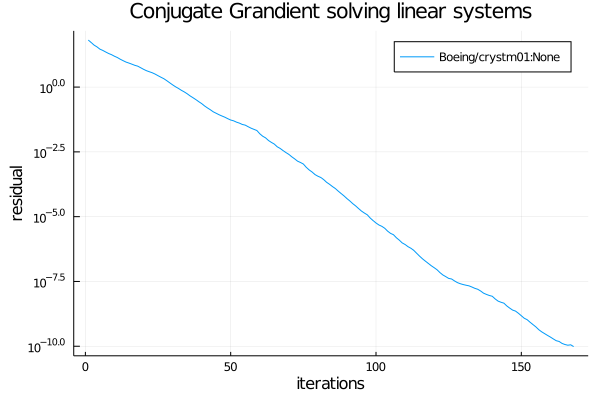

In [30]:
#standard CG
x, errors = CG(crystm01, b, x₀;verbosity = verb)
@info "Required iteration number without preconditioner is: " size(errors,1)
Plots.plot(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":None", ylabel = "residual", xlabel = "iterations", yaxis=:log)

┌ Info: Required iteration number with Jacobi preconditioner is: 
│   size(errors, 1) = 71
└ @ Main In[31]:5


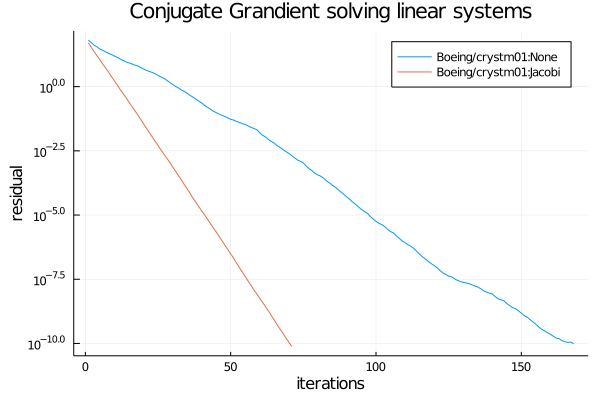

In [31]:
## Construct the Jacobi precontioning matrix as (diag(A))^{-1}
PJacobi = inv(Diagonal(crystm01d))
## Appy the Jacobi preconditioning matrix to PCG
x, errors = PCG(crystm01, b, x₀, PJacobi; verbosity = verb)
@info "Required iteration number with Jacobi preconditioner is: " size(errors,1)
Plots.plot!(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":Jacobi", ylabel = "residual", xlabel = "iterations", yaxis=:log)

┌ Info: Required iteration number with SSOR preconditioner is: 
│   size(errors, 1) = 28
└ @ Main In[32]:7


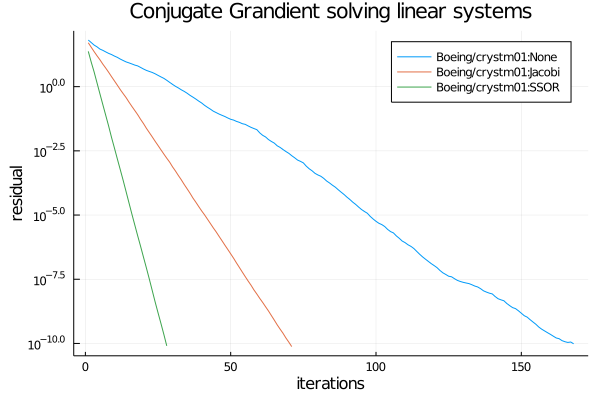

In [32]:
## Construct the SSOR precontioning matrix by function SSOR(A; ω=1.8)
ω = 1.8
PSSOR = inv(SSOR(crystm01d; ω=ω))

## Appy the SSOR preconditioning matrix to PCG
x, errors = PCG(crystm01, b, x₀, PSSOR; verbosity = verb)
@info "Required iteration number with SSOR preconditioner is: " size(errors,1)
Plots.plot!(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":SSOR", ylabel = "residual", xlabel = "iterations", yaxis=:log)

In [33]:
## recording timings for diferent kernels
CG(crystm01, b, x₀;verbosity = 0, timer=true);

PCG(crystm01, b, x₀, SparseMatrixCSC(PJacobi); verbosity = 0, timer=true);

PCG(crystm01, b, x₀, PSSOR; verbosity = 0, timer=true);

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:     53.4ms / 100%            43.9MiB / 100%     

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 Total          1   53.4ms   100%  53.4ms   43.9MiB  100%   43.9MiB
   SpMV       169   26.4ms  49.4%   156μs   6.34MiB  14.4%  38.4KiB
   Axpy       503   26.1ms  48.8%  51.9μs   37.5MiB  85.5%  76.4KiB
   Dot        337    591μs  1.11%  1.75μs     0.00B  0.00%    0.00B
   Copy         1    296ns  0.00%   296ns     0.00B  0.00%    0.00B
 ────────────────────────────────────────────────────────────────── ────────────────────────────────────────────────────────────────────────
                                 Time                   Allocations      
                         ───────────

In [34]:
## Compute condition number of precondtioned linear system
LJacobi = sqrt.(Diagonal(crystm01d))
@info "Condition number of Jacobi preconditioned linear system" cond(inv(LJacobi) * crystm01d * (inv(LJacobi))' )

DSSOR = LinearAlgebra.Diagonal(crystm01d)
LSSOR = LinearAlgebra.LowerTriangular(crystm01d)
LSSOR = sqrt(ω/(2-ω)) .* ((1/ω) .* DSSOR + LSSOR) * sqrt.((inv(DSSOR)))
@info "Condition number of SSOR preconditioned linear system" cond(inv(LSSOR) * crystm01d * (inv(LSSOR))' ) 

┌ Info: Condition number of Jacobi preconditioned linear system
│   cond(inv(LJacobi) * crystm01d * (inv(LJacobi))') = 27.01961235906221
└ @ Main In[34]:3
┌ Info: Condition number of SSOR preconditioned linear system
│   cond(inv(LSSOR) * crystm01d * (inv(LSSOR))') = 4.775302994339138
└ @ Main In[34]:8


ToDo: Please fill in the table below with the previously obtained data

| Boeing/crystm01 | None | Jacobi | SSOR |
| :------: | :------: | :------: | :------: |
|Iteration number|165|71|28|
|Condition number|228.316|27.019|4.775|
|Total Time(s)|0.045|0.033|0.523|
|SpMV Time(s)|0.02|0.012|0.065|
|MV(Precond) Time(s)|-|0.003|0.507|

### Matrix: Bai/mhd3200b

In [35]:
matname = "Bai/mhd3200b"

verb = 0

mhd3200b = MatrixDepot.matrixdepot(matname)
mhd3200bd = Matrix(mhd3200b)
M = size(mhd3200b, 1)
N = size(mhd3200b, 2);

b = randn(eltype(mhd3200b), N)
x₀ = randn(eltype(mhd3200b), N);

┌ Info: Required iteration number without preconditioner is: 
│   size(errors, 1) = 5000
└ @ Main In[36]:3


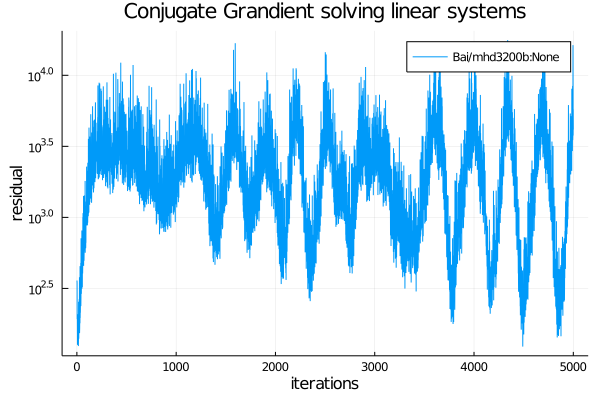

In [36]:
#standard CG
x, errors = CG(mhd3200b, b, x₀;verbosity = verb)
@info "Required iteration number without preconditioner is: " size(errors,1)
Plots.plot(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":None", ylabel = "residual", xlabel = "iterations", yaxis=:log)

┌ Info: Required iteration number with Jacobi preconditioner is: 
│   size(errors, 1) = 56
└ @ Main In[37]:5


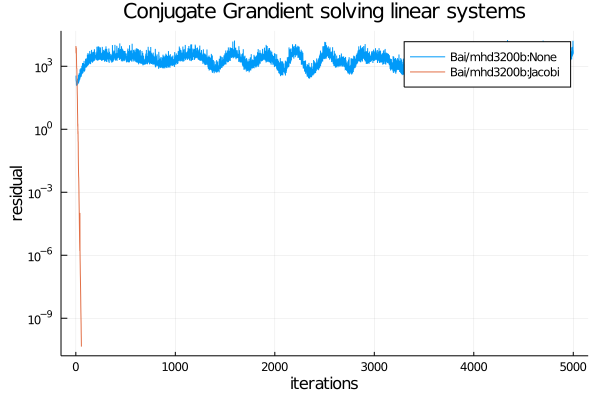

In [37]:
## Construct the Jacobi precontioning matrix as (diag(A))^{-1}
PJacobi = inv(Diagonal(mhd3200bd))
## Appy the Jacobi preconditioning matrix to PCG
x, errors = PCG(mhd3200b, b, x₀, PJacobi; verbosity = verb)
@info "Required iteration number with Jacobi preconditioner is: " size(errors,1)
Plots.plot!(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":Jacobi", ylabel = "residual", xlabel = "iterations", yaxis=:log)

┌ Info: Required iteration number with SSOR preconditioner is: 
│   size(errors, 1) = 31
└ @ Main In[38]:7


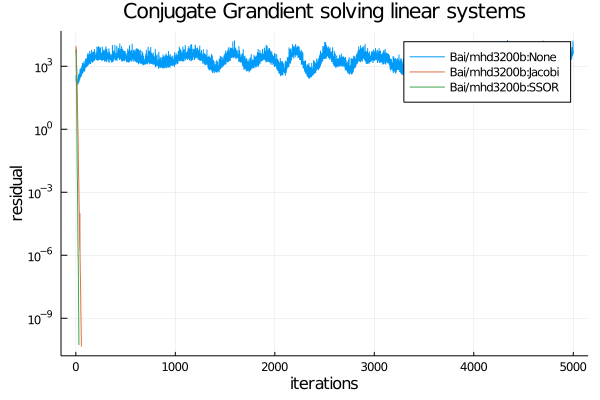

In [38]:
## Construct the SSOR precontioning matrix by function SSOR(A; ω=1.8)
ω = 1.8
PSSOR = inv(SSOR(mhd3200bd; ω=ω))

## Appy the SSOR preconditioning matrix to PCG
x, errors = PCG(mhd3200b, b, x₀, PSSOR; verbosity = verb)
@info "Required iteration number with SSOR preconditioner is: " size(errors,1)
Plots.plot!(errors, title = "Conjugate Grandient solving linear systems", label = matname * ":SSOR", ylabel = "residual", xlabel = "iterations", yaxis=:log)

In [39]:
## recording timings for diferent kernels
CG(mhd3200bd, b, x₀;verbosity = 0, timer=true);

PCG(mhd3200bd, b, x₀, SparseMatrixCSC(PJacobi); verbosity = 0, timer=true);

PCG(mhd3200bd, b, x₀, PSSOR; verbosity = 0, timer=true);

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      17.3s / 100%             857MiB / 100%     

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 Total          1    17.3s   100%   17.3s    857MiB  100%    857MiB
   SpMV     5.00k    16.8s  97.2%  3.36ms    123MiB  14.3%  25.1KiB
   Axpy     15.0k    434ms  2.51%  28.9μs    735MiB  85.7%  50.2KiB
   Dot      10.0k   23.5ms  0.14%  2.35μs     0.00B  0.00%    0.00B
   Copy         1    583ns  0.00%   583ns     0.00B  0.00%    0.00B
 ────────────────────────────────────────────────────────────────── ────────────────────────────────────────────────────────────────────────
                                 Time                   Allocations      
                         ───────────

In [40]:
## Compute condition number of precondtioned linear system
LJacobi = sqrt.(Diagonal(mhd3200bd))
@info "Condition number of Jacobi preconditioned linear system" cond(inv(LJacobi) * mhd3200bd * (inv(LJacobi))' )

DSSOR = LinearAlgebra.Diagonal(mhd3200bd)
LSSOR = LinearAlgebra.LowerTriangular(mhd3200bd)
LSSOR = sqrt(ω/(2-ω)) .* ((1/ω) .* DSSOR + LSSOR) * sqrt.((inv(DSSOR)))
@info "Condition number of SSOR preconditioned linear system" cond(inv(LSSOR) * mhd3200bd * (inv(LSSOR))' ) 

┌ Info: Condition number of Jacobi preconditioned linear system
│   cond(inv(LJacobi) * mhd3200bd * (inv(LJacobi))') = 29.183039245907167
└ @ Main In[40]:3
┌ Info: Condition number of SSOR preconditioned linear system
│   cond(inv(LSSOR) * mhd3200bd * (inv(LSSOR))') = 8.800512608154916
└ @ Main In[40]:8


ToDo: Please fill in the table below with the previously obtained data

| Bai/mhd3200b | None | Jacobi | SSOR |
| :------: | :------: | :------: | :------: |
|Iteration number|>5000|56|31|
|Condition number|1.60398e+13|29.18304|8.80051|
|Total Time(s)|>18.8|0.237|0.281|
|SpMV Time(s)|18.1|0.229|0.141|
|MV(Precond) Time(s)|-|0.001|0.137|

Question 1:
> Can you explain the relation between the condition number and convergence behaviour?

Answer:
> Larger condition number, more difficult to converge. Preconditioners can reduce the condition numbers, which accelerate the convergence.

Question 2:
> Please try to summarize the strategy to select different preconditioners (or without preconditioning).

Answer:
> Tradeoff

(Tips: please consider the tradeoff between convergence behaviour and time-to-solution.)